# CN-Wheat: Physiological tasks

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

In [2]:

filename = 'results_cnwheat_base_extra_envs.csv'
data = pd.read_csv(filename, index_col=0)

targets = data['target_id'].unique().tolist()
state_vars = data['reservoir_id'].unique().tolist()
datasets = data['dataset_id'].unique().tolist()

data = data.set_index(['target_id', 'reservoir_id', 'dataset_id'])
data = data.sort_values(['target_id', 'reservoir_id', 'dataset_id'], axis=0)

print(state_vars)

['state__An', 'state__Transpiration', 'state__Ts', 'state__gs', 'state__Ag', 'state__Tr', 'state__Rd', 'state__sum_respi', 'state__PARa', 'state__het_all', 'env_all', 'env_temp', 'env_humidity', 'env_PAR']


In [3]:
from model_config_cnwheat import output_targets

## Visualizations

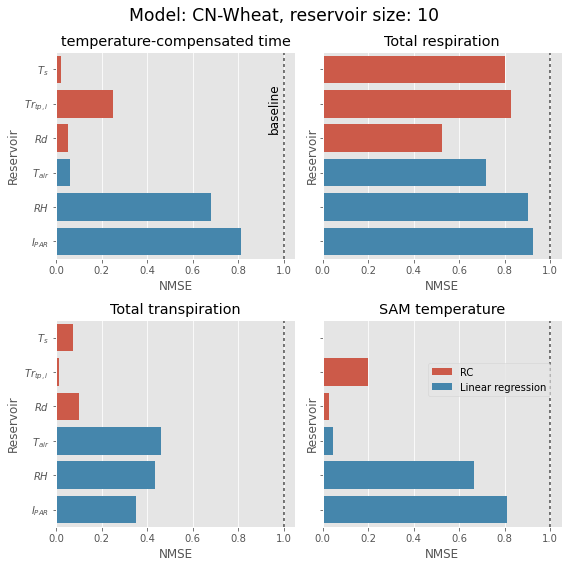

In [18]:
from model_config_cnwheat import (input_names, measurable_reservoirs, best_reservoirs, input_symbols,
output_names, state_symbols, state_units, state_names, baseline_symbols)


DATASET = 'NEMA_combined'
# TARGETS = output_targets
TARGETS = [
  'output__axes__delta_teq',
  'output__axes__sum_respi_shoot',
  'output__axes__Total_Transpiration',
  'output__axes__SAM_temperature',
]

BASELINE_RESERVOIRS = ['env_temp', 'env_humidity', 'env_PAR']
PLANT_RESERVOIRS = best_reservoirs


with plt.style.context('ggplot'):
    # setup figure
    n_cols = 2
    n_rows = int(np.ceil(len(TARGETS) / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8, 4 * n_rows), squeeze=False, sharey=True, sharex=False)

    for target, ax in zip(TARGETS, axs.flatten()):

      res_data = data.loc[target, PLANT_RESERVOIRS, DATASET].reset_index()
      res_data['reservoir_type'] = 'RC'
      res_data['reservoir_id'] = res_data['reservoir_id'].apply(lambda x: state_symbols[x])

      env_data = data.loc[target, BASELINE_RESERVOIRS, DATASET].reset_index()
      env_data['reservoir_type'] = 'Linear regression'
      env_data['reservoir_id'] = env_data['reservoir_id'].apply(lambda x: baseline_symbols[x])

      plot_data = pd.concat((res_data, env_data), ignore_index=True)
      plot_data['test_score'] *= -1
      

      # create data plots
      g = sns.barplot(y='reservoir_id', x='test_score', data=plot_data, ax=ax, orient='h', hue='reservoir_type',
      dodge=False)

      # plot baseline score dashed line
      ax.axvline(1, dashes=(2, 2), color='black', alpha=0.67)
      if ax is axs[0, 0]:
        ax.text(0.93, 1.8, 'baseline', fontsize='large', rotation='vertical')

      # Figure ticks, labels and titles
      ax.set_xlabel("NMSE")
      ax.set_ylabel("Reservoir")
      ax.set_title(f'{output_names[target]}')

      # Legend
      if ax is axs[0, 0]:
        handles, labels = ax.get_legend_handles_labels()
        # fig.legend(handles, labels, bbox_to_anchor=(0.47, 0.85), fontsize='medium')
        fig.legend(handles, labels, bbox_to_anchor=(0.97, 0.37), fontsize='medium')

      ax.legend_.remove()


    plt.suptitle(f'Model: CN-Wheat, reservoir size: 10', fontsize='xx-large')
    plt.tight_layout()
    plt.savefig(os.path.join('figures/', f'cnwheat__physiological_tasks.png'), dpi=200, bbox_inches='tight')

